In [1]:
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import math
import time
from keras.datasets import mnist

In [2]:
n_samples = 100

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images[:n_samples]
train_labels = train_labels[:n_samples]

test_images = test_images[:n_samples]
test_labels = test_labels[:n_samples]

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

In [3]:
def getEuclideanDistance(single_point,array):
    nrows, ncols, nfeatures=array.shape[0],array.shape[1], array.shape[2]
    points=array.reshape((nrows*ncols,nfeatures))
                         
    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    dist=dist.reshape((nrows,ncols))
    return dist

In [4]:
mu, sigma = 0, 0.1
A = np.random.normal(mu, sigma, 10)
#A.shape, A

In [5]:
nrows,ncols,nfeatures=3,3,3

#Generate coordinate system
x,y=np.meshgrid(range(ncols),range(nrows))

In [6]:

sgm0=2
sgmdecay=0.05
t=1
sgm = sgm0 * math.exp(-t*sgmdecay);

width = math.ceil(sgm*3)

dist=np.array([[2,1,3],[3,2,3],[4,4,4]])
bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) 

g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));


fromrow = max(0,bmurow - width);
torow   = min(bmurow + width,nrows);
fromcol = max(0,bmucol - width);
tocol   = min(bmucol + width,ncols);

In [7]:
G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

In [8]:
def display_som(som, nrows, ncols, dispRes, title):
    print("\n" + title + "\n")
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    for k in range(nrows):
        for l in range(ncols):
            A = som[k, l, :].reshape(dispRes)
            ax[k, l].imshow(A, cmap="plasma")
            ax[k, l].set_yticks([])
            ax[k, l].set_xticks([])
    plt.show()

In [9]:
def SOM (dispRes, trainingData, ndim=10, nepochs=10, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    mu, sigma = 0, 0.1
    numpy.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows,ncols,nfeatures))

    if showMode >= 1:
        print("\nSOM features before training: \n")
        
        fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        for k in range(nrows):
            for l in range (ncols):
                A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
                ax[k,l].imshow(A,cmap="plasma")
                ax[k,l].set_yticks([])
                ax[k,l].set_xticks([])   
    
    #Generate coordinate system
    x,y=np.meshgrid(range(ncols),range(nrows))
    
    
    for t in range (1,nepochs+1):
        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t*etadecay);
        
        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t*sgmdecay);
        
        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3);
        
        for ntraining in range(ntrainingvectors):
            trainingVector = trainingData[ntraining,:];
            
            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = getEuclideanDistance(trainingVector, som);
       
            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
            
            
            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));

            #Determine the boundary of the local neighbourhood
            fromrow = max(0,bmurow - width);
            torow   = min(bmurow + width,nrows);
            fromcol = max(0,bmucol - width);
            tocol   = min(bmucol + width,ncols);

            
            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbourNeurons = som[fromrow:torow,fromcol:tocol,:];
            sz = neighbourNeurons.shape;
            
            #Transform the training vector and the Gaussian function into 
            # multi-dimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(trainingVector,sz[0]*sz[1],1).reshape((sz[0],sz[1],nfeatures));                   
            G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons);

            
            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow,fromcol:tocol,:] = neighbourNeurons;
    
        # Intermediate display at 50% of iterations
        if showMode >= 1 and t == nepochs // 2:
            display_som(som, nrows, ncols, dispRes, "SOM features at 50% training")

    if showMode >= 1:
        display_som(som, nrows, ncols, dispRes, "SOM features AFTER training")
        
    return som
    

In [10]:
import pandas as pd
def parse_input_zoo_data(filename, header='infer'):

    input_data = pd.read_csv(filename, header=header)

    classes = input_data[17].tolist()
    labels = input_data[0].tolist()
    input_database = {
        0: input_data[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].to_numpy()
    }

    return input_database, labels, classes

In [11]:
input_filename = 'zoo.txt'
input_vector_database, labels, classes = parse_input_zoo_data(input_filename,None)


SOM features before training: 


SOM features at 50% training



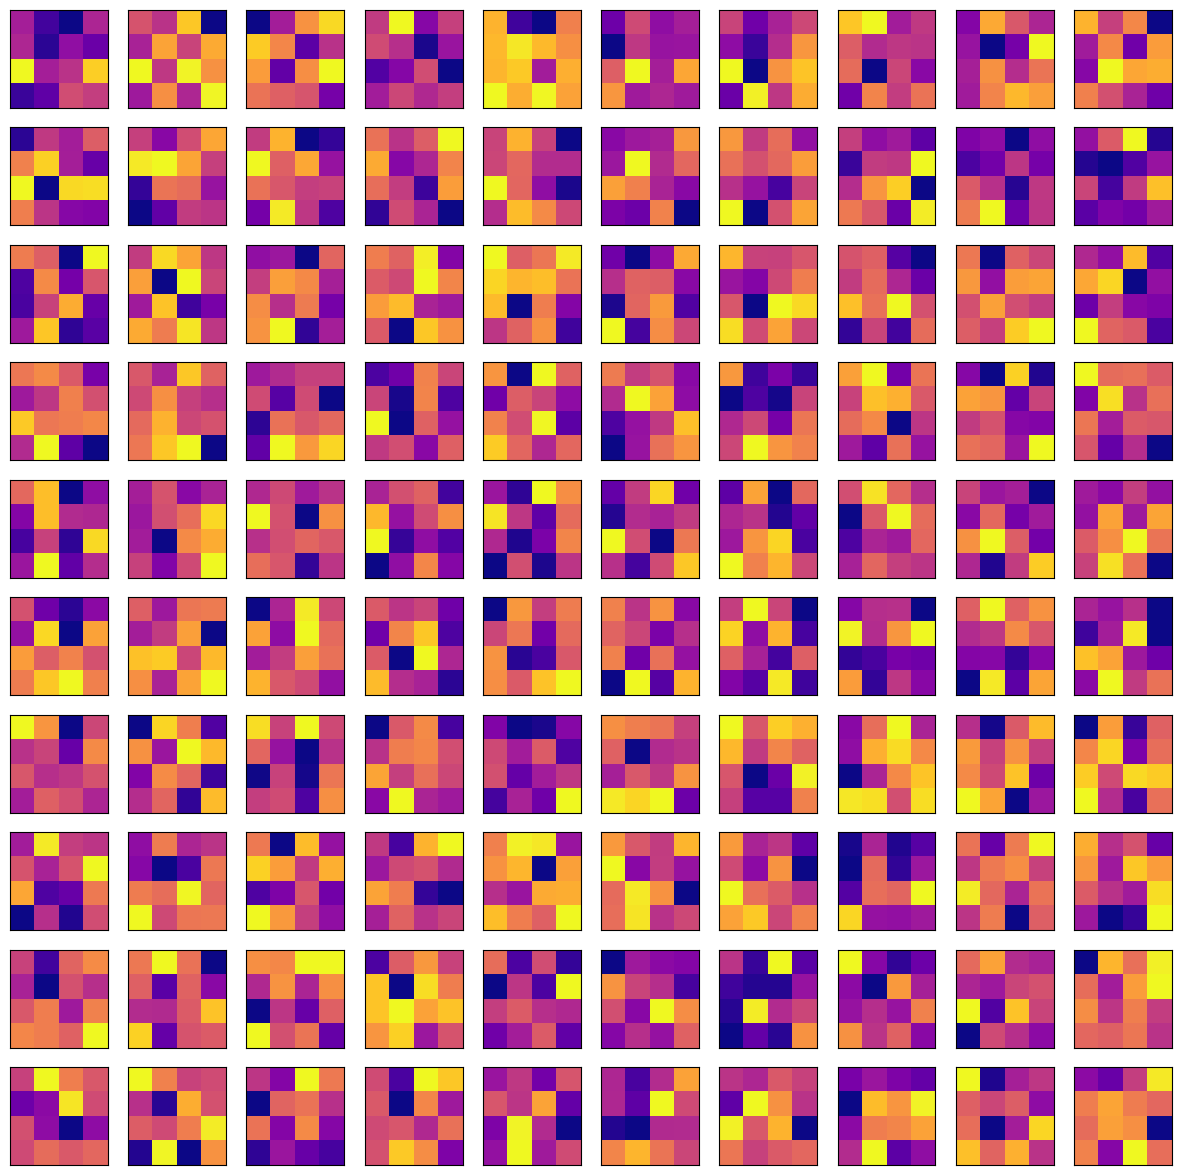

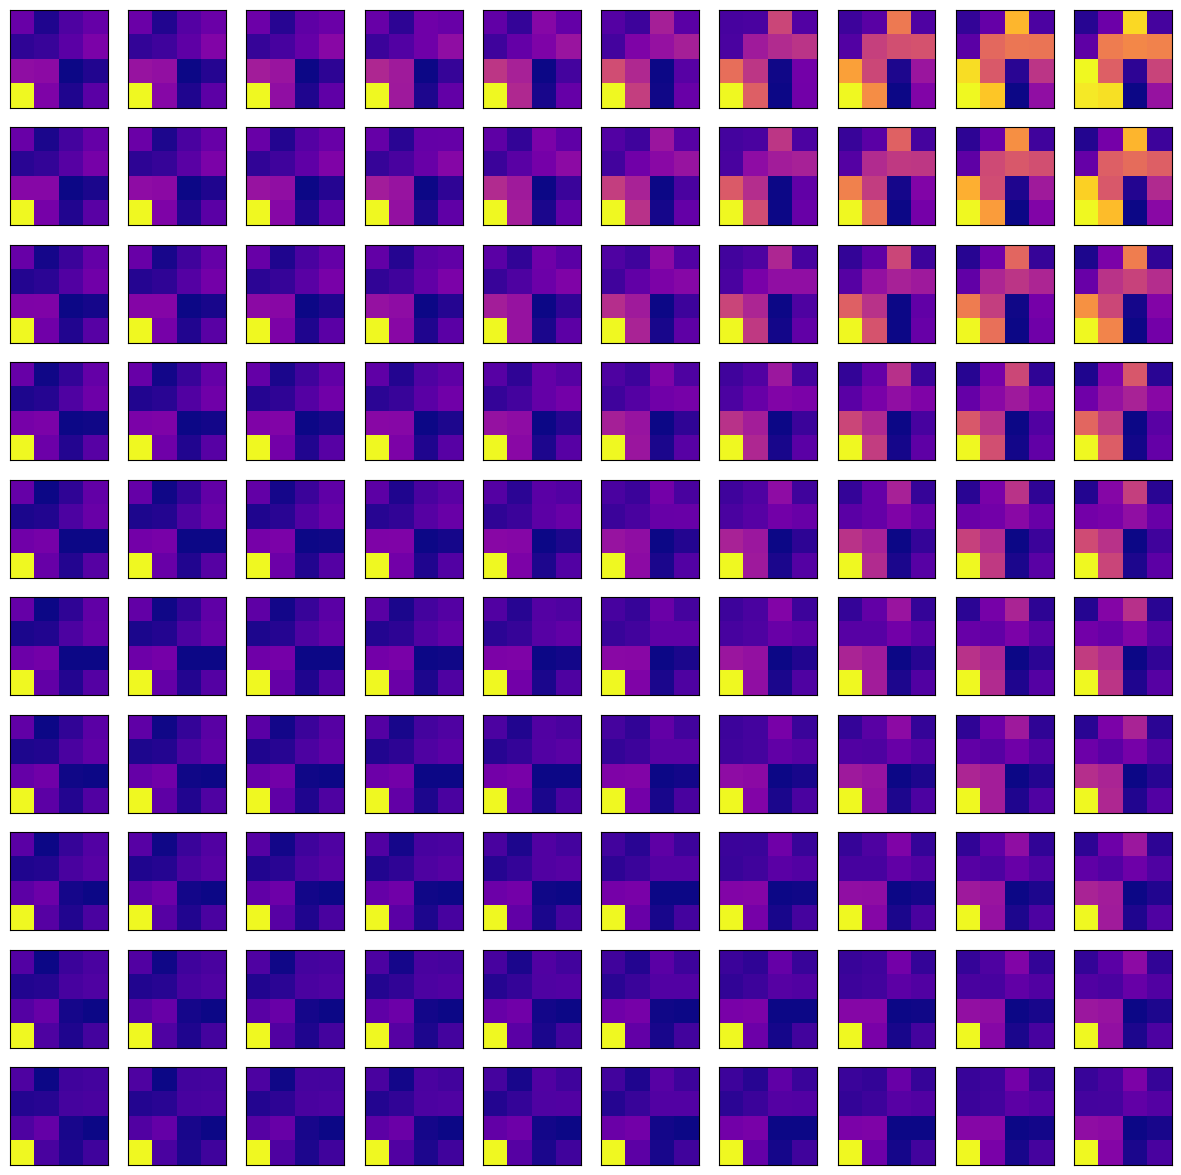


SOM features AFTER training



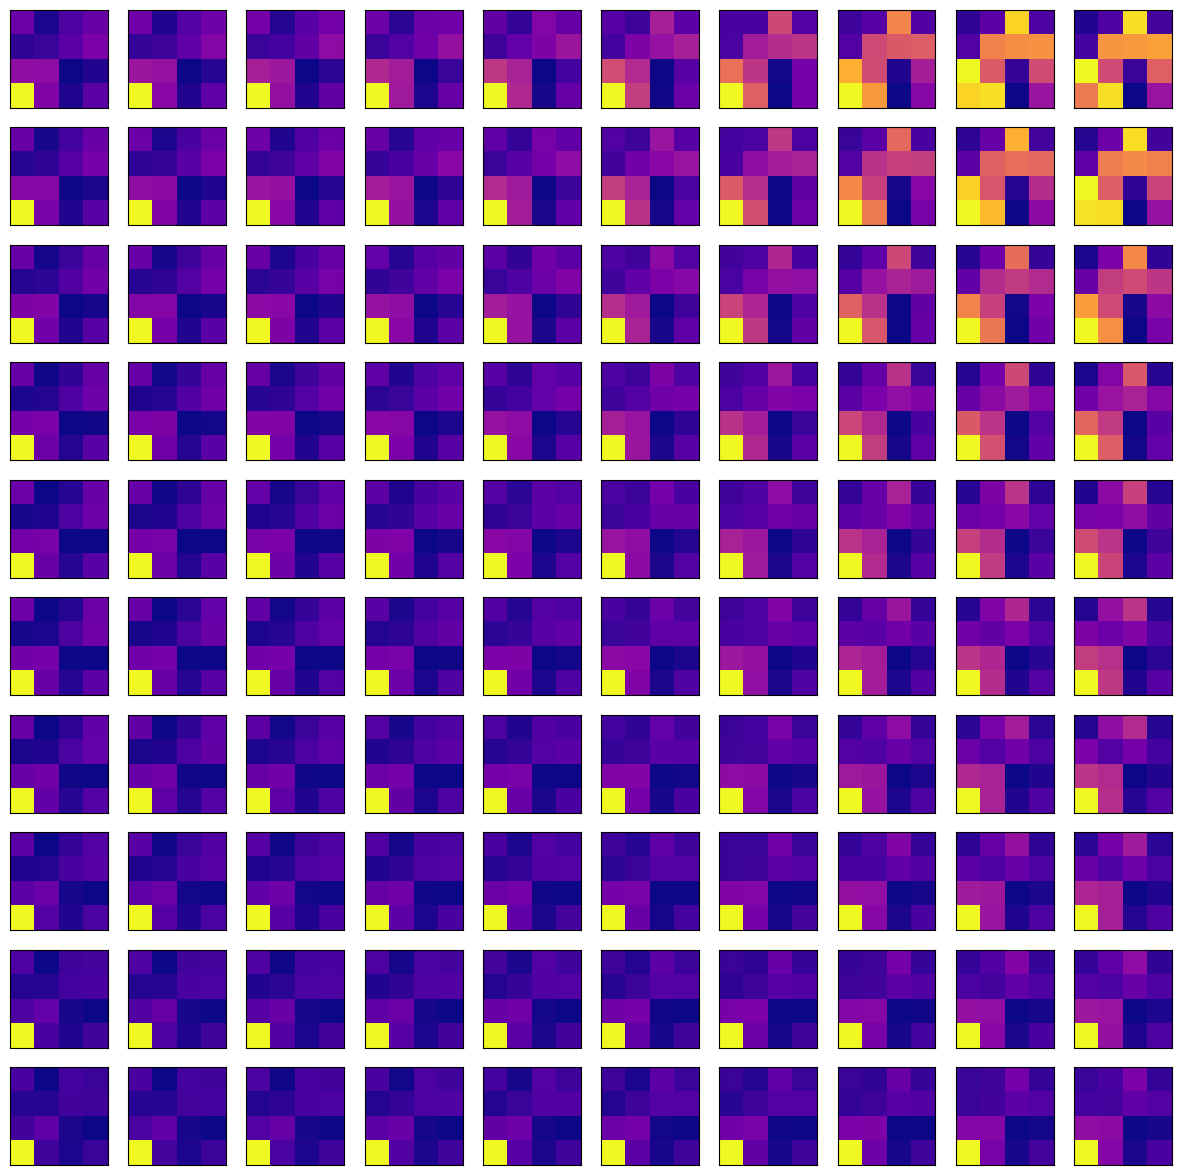

In [12]:
som_trained=SOM ([4,4],input_vector_database[0], ndim=10, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)

In [13]:
plt.show()


SOM features before training: 


SOM features at 50% training



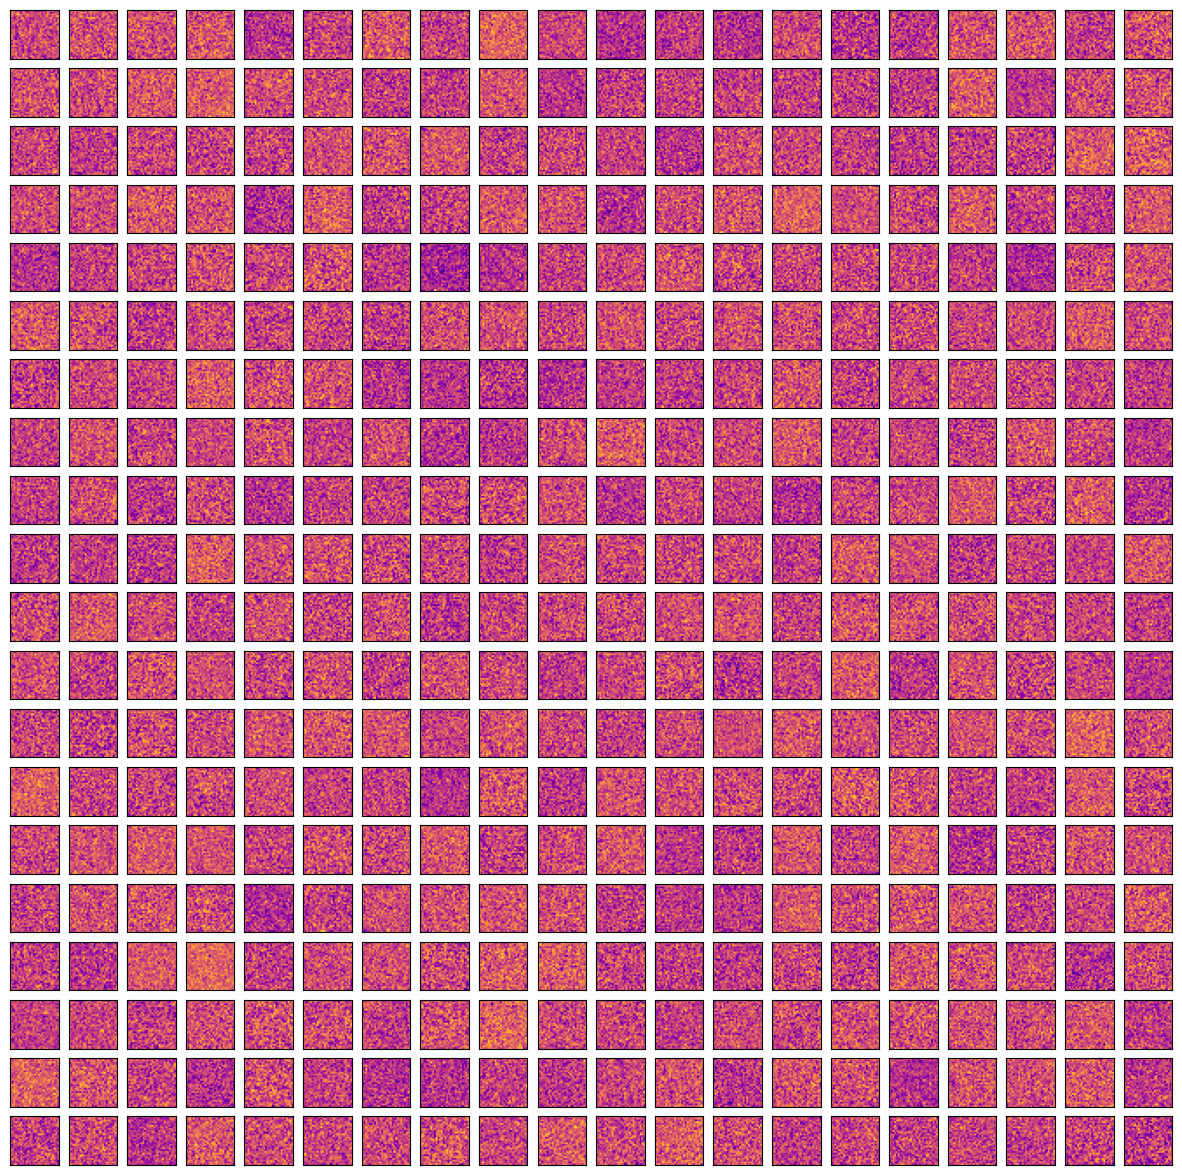

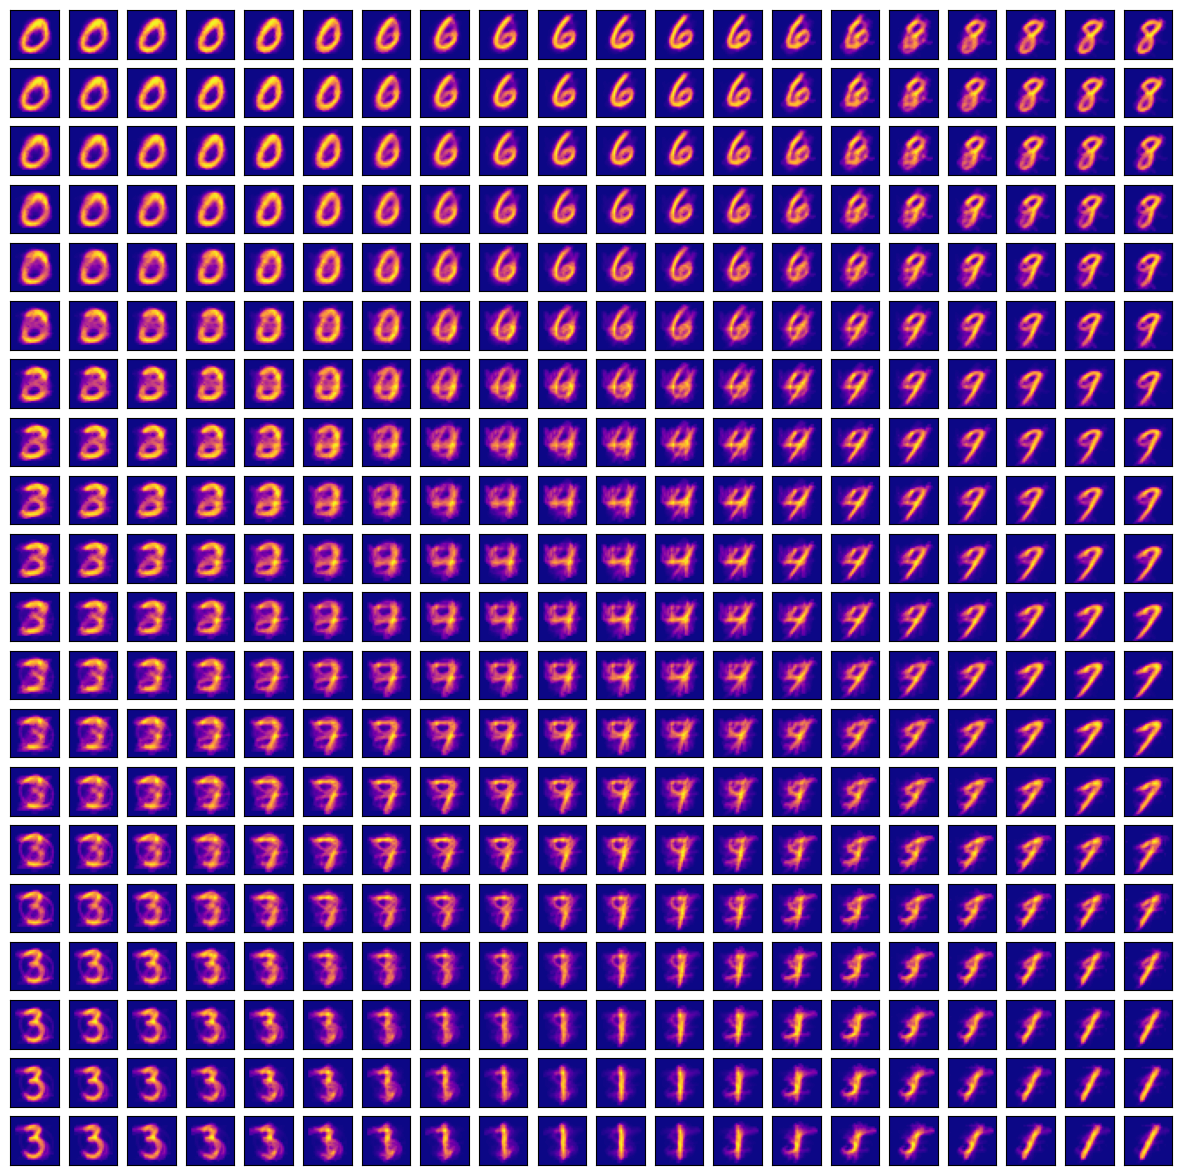


SOM features AFTER training



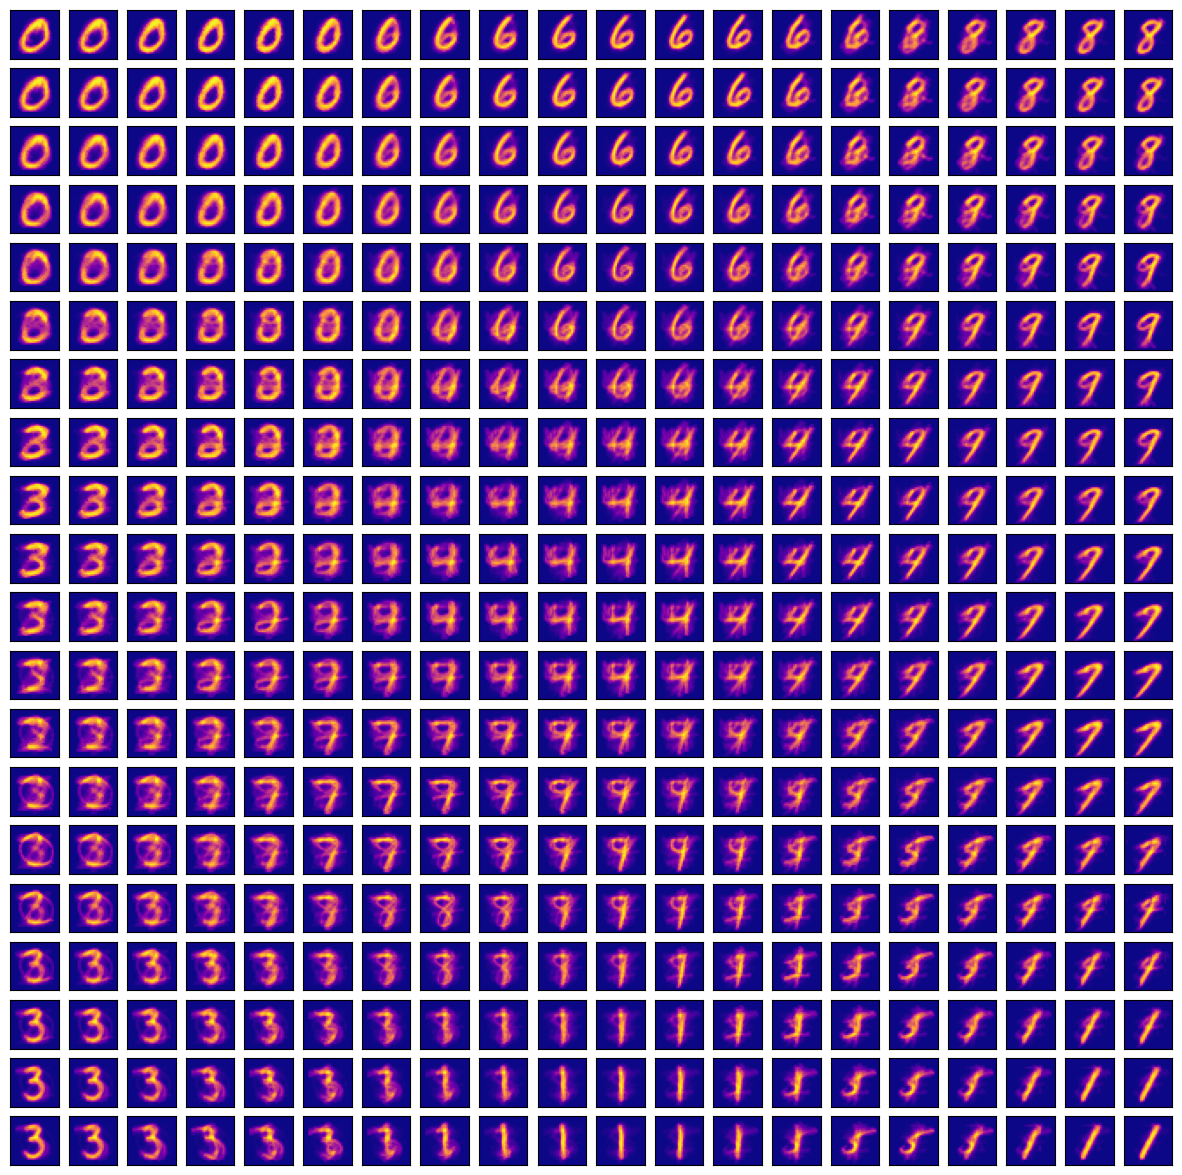

[[[ 5.44764900e-32  9.79740401e-32  3.20754653e-31 ...  1.19323393e-31
   -3.83054152e-31 -5.85028324e-31]
  [-3.85904992e-32  8.20043283e-33  6.08320668e-32 ... -2.59184124e-32
   -1.40862131e-33 -1.39312024e-33]
  [-4.66259606e-34  2.73199776e-32  6.20757238e-33 ...  1.40151096e-32
   -4.51773518e-33 -1.02996921e-32]
  ...
  [ 4.53628358e-31  9.90981223e-32  3.10732034e-31 ...  1.26710657e-31
    5.25610023e-31  1.09093298e-31]
  [-2.40519544e-30  1.14692026e-30 -2.43132375e-30 ...  4.42733961e-31
   -3.58632141e-30  6.29067508e-31]
  [ 1.66703723e-29  2.22433073e-29  4.98378361e-30 ...  1.15206232e-29
    9.44173648e-30  1.36773182e-29]]

 [[-1.05641878e-33  4.69600375e-32  7.79945150e-34 ...  2.28621813e-32
    8.63703844e-32  4.41298097e-32]
  [-4.06643160e-33  5.65339445e-33  7.37788941e-33 ... -6.16880443e-33
   -3.75363573e-33  4.72559592e-33]
  [-1.28581473e-34 -1.84394452e-33  2.02396389e-34 ... -1.54963310e-33
   -3.73606714e-34 -1.79500350e-33]
  ...
  [ 1.65342029e-32 -5.0

In [14]:
ndim20 = 20
ndim40 = 40
ndim80 = 80

som_trained_20x20 = SOM([28, 28], train_images_flattened, ndim=ndim20, nepochs=100, showMode=1)

print(som_trained_20x20)

plt.show()

In [15]:
#som_trained_40x40 = SOM([28, 28], train_images_flattened, ndim=ndim40, nepochs=100, showMode=1)
plt.show()

In [16]:
#som_trained_80x80 = SOM([28, 28], train_images_flattened, ndim=ndim80, nepochs=100, showMode=1)
plt.show()

In [17]:
#verification of correctness on the training set:
def SOM_Test (trainingData, som_, classes, grid_, ConfusionMatrix, ndim=60):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    nclasses=np.max(classes)

    som_cl=np.zeros((ndim,ndim,nclasses+1))
    
    
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        
        som_cl[bmurow, bmucol,class_of_sample]=som_cl[bmurow, bmucol,class_of_sample]+1
    
    
    
    for i in range (nrows):
        for j in range (ncols):
            grid_[i,j]=np.argmax(som_cl[i,j,:])

 
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        predicted=np.argmax(som_cl[bmurow, bmucol,:])
        ConfusionMatrix[class_of_sample-1, predicted-1]=ConfusionMatrix[class_of_sample-1, predicted-1]+1
        
    return grid_, ConfusionMatrix

In [40]:
def getConfusionMatrix(train_images, SOM, ndim=20):
    nrows=ndim
    ncols=ndim
    grid_color=np.zeros((nrows,ncols))
    nclasses=np.max(classes)

    Confusion_Matrix=np.zeros((nclasses,nclasses))
    grid_color,Confusion_Matrix=SOM_Test (train_images, SOM, classes, grid_color, Confusion_Matrix, ndim)

    plt.close()
    plt.imshow(grid_color)
    plt.show()

    return Confusion_Matrix, train_images_flattened.shape, np.sum(Confusion_Matrix)

In [41]:
def calulateAccuracy(Confusion_Matrix):
    true_positives = np.trace(Confusion_Matrix)

    # Calculate the total number of samples (the sum of all elements in the confusion matrix)
    total_samples = np.sum(Confusion_Matrix)

    # Calculate accuracy
    accuracy = true_positives / total_samples

    print("Accuracy:", accuracy)

Training Set


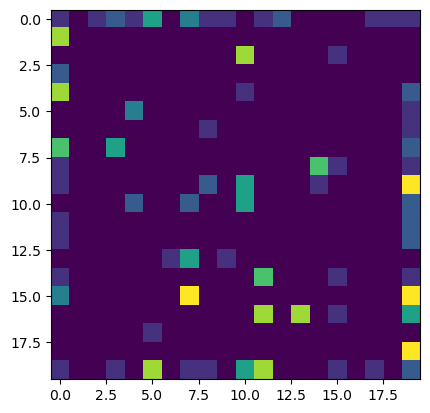

[[40.  1.  0.  0.  0.  0.  0.]
 [ 4. 15.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 5.  1.  0.  7.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 1.  0.  0.  0.  0.  7.  0.]
 [ 1.  3.  0.  1.  0.  1.  4.]]
Accuracy: 0.79
Test Set


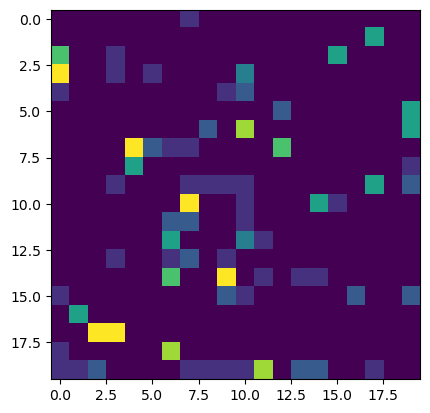

[[40.  0.  0.  0.  0.  0.  1.]
 [ 5. 14.  0.  0.  0.  0.  0.]
 [ 3.  0.  2.  0.  0.  0.  0.]
 [ 2.  1.  0. 10.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 2.  1.  0.  1.  0.  4.  0.]
 [ 1.  0.  1.  0.  0.  1.  7.]]


In [50]:
# 5
print("Training Set")
confusion_matrix, shape, sum_matrix = getConfusionMatrix(train_images_flattened, som_trained_20x20, ndim20)
print(confusion_matrix)
calulateAccuracy(confusion_matrix)

print("Test Set")
confusion_matrix, shape, sum_matrix = getConfusionMatrix(test_images_flattened, som_trained_20x20, ndim20)
print(confusion_matrix)


In [49]:
'''from sklearn.metrics import confusion_matrix, accuracy_score

def assign_labels_to_neurons(som, train_data, train_labels, ndim=20):
    """
    Assigns a label to each neuron in the SOM based on the most frequent class
    it maps to in the training data.
    """
    neuron_labels = np.zeros((ndim, ndim), dtype=int)
    for x in range(ndim):
        for y in range(ndim):
            # Find all training examples that are closest to this neuron
            distances = np.linalg.norm(train_data - som[x, y, :], axis=1)
            closest = np.argmin(distances)
            # Assign the label of the closest training example to the neuron
            neuron_labels[x, y] = train_labels[closest]
    return neuron_labels

# After training your SOM with the MNIST training data:
neuron_labels = assign_labels_to_neurons(som_trained_20x20, train_images_flattened, train_labels, ndim20)

def calculate_confusion_matrix(som, data, labels, neuron_labels, ndim):
    """
    Calculates the confusion matrix for the given data and labels using the trained SOM.
    """
    confusion_matrix = np.zeros((10, 10), dtype=int)
    for i in range(len(data)):
        # Find the best matching unit for each data point
        distances = np.linalg.norm(data[i] - som.reshape(-1, data.shape[1]), axis=1)
        closest = np.argmin(distances)
        # Determine the position of the neuron
        x, y = closest // ndim, closest % ndim
        # Increment the confusion matrix
        actual_label = labels[i]
        predicted_label = neuron_labels[x, y]
        confusion_matrix[actual_label, predicted_label] += 1
    return confusion_matrix

# Calculate the confusion matrix for the training set
train_conf_matrix = calculate_confusion_matrix(som_trained_20x20, train_images_flattened, train_labels, neuron_labels, ndim20)

# Calculate the confusion matrix for the test set
test_conf_matrix = calculate_confusion_matrix(som_trained_20x20, test_images_flattened, test_labels, neuron_labels, ndim20)

# Function to display confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(train_labels)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Display the confusion matrix for the training set
plot_confusion_matrix(train_conf_matrix, title='Confusion matrix for TRAINING set')

# Display the confusion matrix for the test set
plot_confusion_matrix(test_conf_matrix, title='Confusion matrix for TEST set')
plt.show()'''

'from sklearn.metrics import confusion_matrix, accuracy_score\n\ndef assign_labels_to_neurons(som, train_data, train_labels, ndim=20):\n    """\n    Assigns a label to each neuron in the SOM based on the most frequent class\n    it maps to in the training data.\n    """\n    neuron_labels = np.zeros((ndim, ndim), dtype=int)\n    for x in range(ndim):\n        for y in range(ndim):\n            # Find all training examples that are closest to this neuron\n            distances = np.linalg.norm(train_data - som[x, y, :], axis=1)\n            closest = np.argmin(distances)\n            # Assign the label of the closest training example to the neuron\n            neuron_labels[x, y] = train_labels[closest]\n    return neuron_labels\n\n# After training your SOM with the MNIST training data:\nneuron_labels = assign_labels_to_neurons(som_trained_20x20, train_images_flattened, train_labels, ndim20)\n\ndef calculate_confusion_matrix(som, data, labels, neuron_labels, ndim):\n    """\n    Calcula


--- Training with learning rate: 0.01 ---


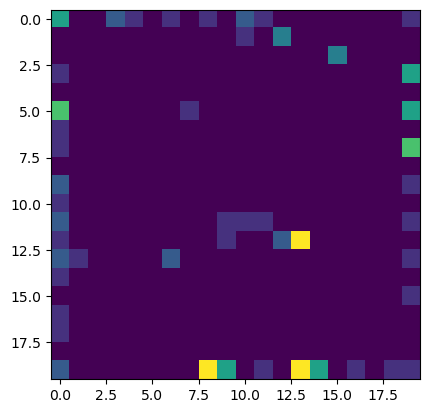

[[36.  3.  0.  2.  0.  0.  0.]
 [ 6. 11.  0.  2.  0.  0.  0.]
 [ 1.  2.  2.  0.  0.  0.  0.]
 [ 3.  2.  0.  8.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  0.  0.]
 [ 6.  1.  0.  0.  0.  0.  1.]
 [ 1.  5.  0.  0.  0.  0.  4.]]
Accuracy: 0.63

--- Training with learning rate: 0.1 ---


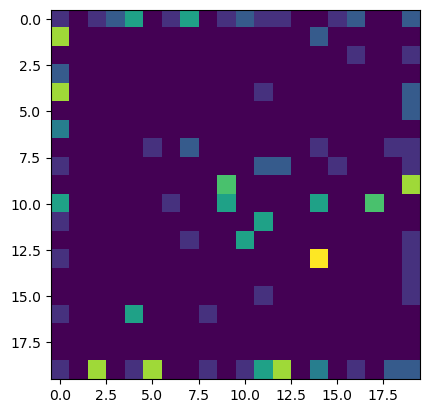

[[39.  2.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 2.  1.  2.  0.  0.  0.  0.]
 [ 3.  0.  1.  9.  0.  0.  0.]
 [ 1.  0.  1.  0.  2.  0.  0.]
 [ 2.  0.  0.  0.  0.  6.  0.]
 [ 3.  4.  0.  1.  0.  1.  1.]]
Accuracy: 0.75

--- Training with learning rate: 0.25 ---


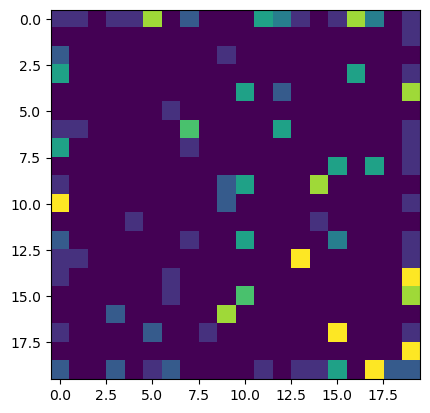

[[40.  1.  0.  0.  0.  0.  0.]
 [ 4. 15.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 2.  0.  0.  0.  2.  0.  0.]
 [ 0.  2.  0.  0.  0.  6.  0.]
 [ 2.  1.  0.  0.  0.  1.  6.]]
Accuracy: 0.83

--- Training with learning rate: 0.5 ---


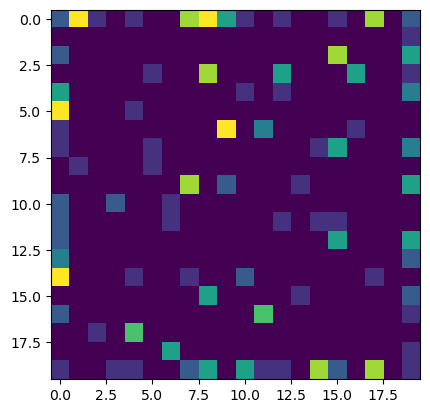

[[40.  1.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 0.  1.  4.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  0.  0.]
 [ 1.  0.  0.  0.  0.  7.  0.]
 [ 0.  4.  0.  0.  0.  1.  5.]]
Accuracy: 0.88

--- Training with learning rate: 0.75 ---


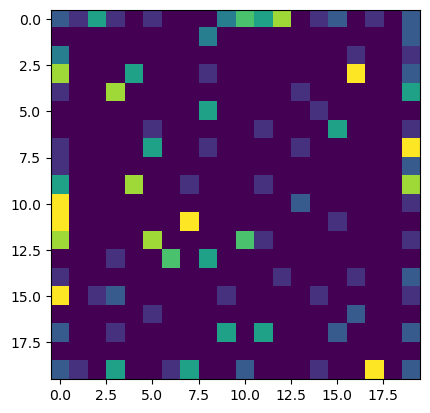

[[41.  0.  0.  0.  0.  0.  0.]
 [ 1. 18.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 0.  3.  0.  0.  0.  0.  7.]]
Accuracy: 0.92

--- Training with learning rate: 0.85 ---


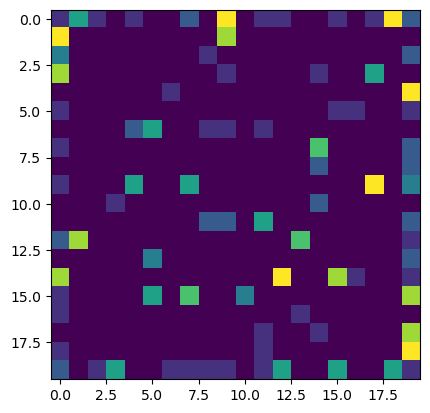

[[40.  1.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 1.  0.  4.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  1.  0.  7.  0.]
 [ 0.  2.  0.  0.  0.  1.  7.]]
Accuracy: 0.88

--- Training with learning rate: 0.95 ---


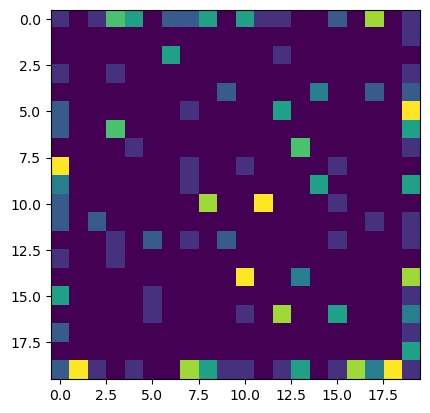

[[40.  1.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 1.  1.  0.  0.  0.  6.  0.]
 [ 0.  1.  0.  2.  0.  1.  6.]]
Accuracy: 0.89


In [53]:
# 6

# learning rates
learning_rates = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85, 0.95]

for eta0 in learning_rates:
    print(f"\n--- Training with learning rate: {eta0} ---")
    som = SOM([28, 28], train_images_flattened, ndim=ndim20, nepochs=100, eta0=eta0, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0)
    
    confusion_matrix, shape, sum_matrix = getConfusionMatrix(train_images_flattened, som, ndim20)
    print(confusion_matrix)
    calulateAccuracy(confusion_matrix)

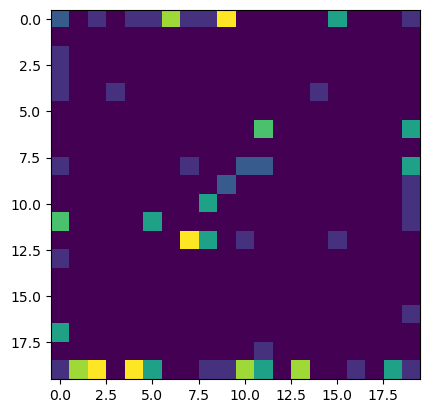

[[38.  3.  0.  0.  0.  0.  0.]
 [10.  9.  0.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 1.  1.  0.  0.  2.  0.  0.]
 [ 3.  0.  0.  0.  1.  4.  0.]
 [ 5.  1.  0.  0.  0.  0.  4.]]
Accuracy: 0.68


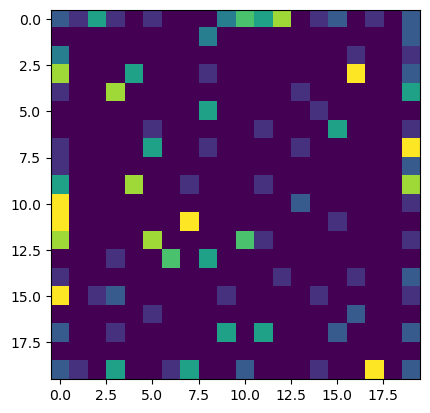

[[41.  0.  0.  0.  0.  0.  0.]
 [ 1. 18.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 0.  3.  0.  0.  0.  0.  7.]]
Accuracy: 0.92


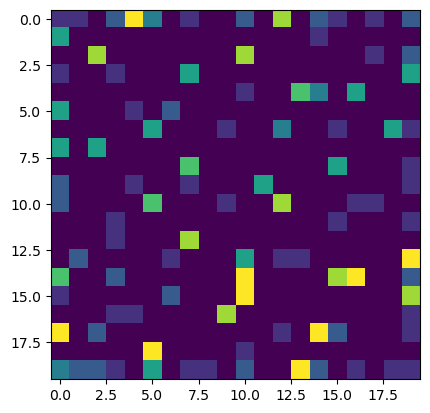

[[41.  0.  0.  0.  0.  0.  0.]
 [ 1. 18.  0.  0.  0.  0.  0.]
 [ 1.  0.  4.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  1.  0.  0.  0.  0.  9.]]
Accuracy: 0.97


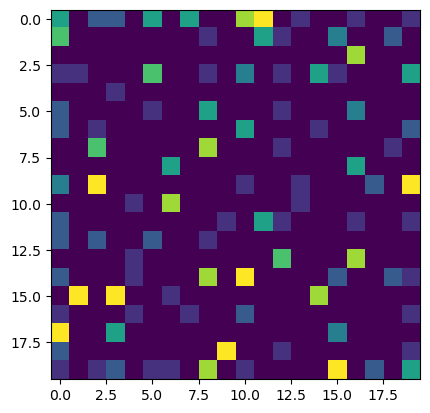

[[41.  0.  0.  0.  0.  0.  0.]
 [ 1. 18.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.]]
Accuracy: 0.99


In [56]:
# 7
# Best learning rate we got: 0.75

sgmdecay_values = [0.01, 0.05, 0.1, 0.5]
for sgmdecay in sgmdecay_values:
    som = SOM([28, 28], train_images_flattened, ndim=20, nepochs=100, eta0=0.75, etadecay=0.05, sgm0=20, sgmdecay=sgmdecay, showMode=0)

    confusion_matrix, shape, sum_matrix = getConfusionMatrix(train_images_flattened, som, ndim20)
    print(confusion_matrix)
    calulateAccuracy(confusion_matrix)